# Introduction to ASD
Autism also known as autism spectrum disorder - A serious developmental disorder that impairs the ability to communicate and interact, is caused by differences in the brain. Autism spectrum disorder impacts the nervous system and affects the overall cognitive, emotional, social and physical health of the affected individual. The range and severity of symptoms can vary widely.

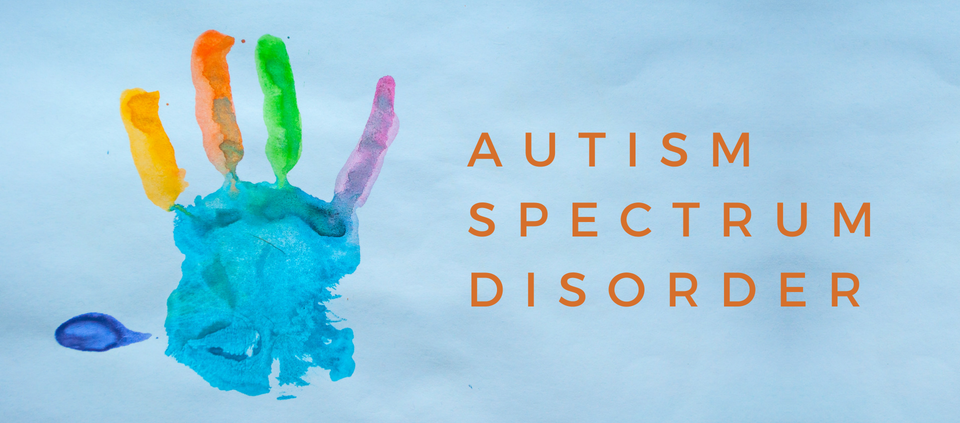

**Symptoms of Autism Spectrum Disorder**

Autism spectrum disorder (ASD) is a developmental disability People with ASD often have problems with social communication and interaction, and restricted or repetitive behaviors or interests. People with ASD may also have different ways of learning, moving, or paying attention. It is important to note that some people without ASD might also have some of these symptoms. But for people with ASD, these characteristics can make life very challenging.

**People may experience:**

* *Behavioural*: inappropriate social interaction, poor eye contact, compulsive behaviour, impulsivity, repetitive movements, self-harm, or persistent repetition of words or actions
* *Developmental*: learning disability or speech delay in a child
* *Cognitive*: intense interest in a limited number of things or problem paying attention
* *Psychological*: unaware of others' emotions or depression
* *Also common*: anxiety, change in voice, sensitivity to sound, or tic

**Treatment consists of therapy**
Early recognition, as well as behavioural, educational and family therapies may reduce symptoms and support development and learning.

# Data Extraction

In [ ]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import preprocessing    
le = preprocessing.LabelEncoder()

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
%matplotlib inline 

from imblearn.over_sampling import RandomOverSampler

from scipy.stats import chi2_contingency

In [ ]:
pip install flaml

In [ ]:
from flaml import AutoML
from flaml.data import get_output_from_log
from flaml.ml import sklearn_metric_loss_score

We have below columns in Train file,
* **ID** - ID of the patient
* **A1_Score to A10_Score** - Score based on Autism Spectrum Quotient (AQ) 10 item screening tool
* **age** - Age of the patient in years
* **gender** - Gender of the patient
* **ethnicity** - Ethnicity of the patient
* **jaundice** - Whether the patient had jaundice at the time of birth
* **autism** - Whether an immediate family member has been diagnosed with autism
* **contry_of_res** - Country of residence of the patient
* **used_app_before** - Whether the patient has undergone a screening test before
* **result** - Score for AQ1-10 screening test
* **age_desc** - Age of the patient
* **relation** - Relation of patient who completed the test
* **Class/ASD** - This is the target column.Classified result as 0 (No) or 1 (Yes).

In [ ]:
train_df = pd.read_csv('../input/autismdiagnosis/Autism_Prediction/train.csv')
test_df  = pd.read_csv('../input/autismdiagnosis/Autism_Prediction/test.csv')

In [ ]:
train_df.shape

In [ ]:
train_df.head(5)

In [ ]:
train_df.info()

In [ ]:
n = train_df.nunique(axis=0)  
print("No.of.unique values in each column :\n", n)

In [ ]:
duplicate = train_df[train_df.duplicated()]
 
print("Duplicate rows count:",duplicate.count())

In [ ]:
train_df.isnull().sum()

# Data Visualization

In [ ]:
sns.color_palette("Paired")
sns.countplot(x="Class/ASD", data=train_df, palette="hls")

**Class/ASD** column is highly imbalanced, and we will handle this data imbalanced.

In [ ]:
sns.histplot(x='age', hue='Class/ASD', data=train_df, bins=20, multiple="stack", kde=True, palette="hls")

In [ ]:
sns.histplot(x='result', hue='Class/ASD', data=train_df, multiple="stack", kde=True, palette="hls")

In [ ]:
sns.scatterplot(x='result', y='age', hue='Class/ASD',data=train_df, palette="hls")

In [ ]:
train_df.groupby('contry_of_res')['Class/ASD'].count().nlargest(10).plot.bar()

In [ ]:
sns.countplot(x="gender", data=train_df, palette="hls")

In [ ]:
#g = sns.PairGrid(train_df)
#g.map(sns.countplot)

# Feature Engineering

In [ ]:
col_list = ['A1_Score','A2_Score','A3_Score','A4_Score','A5_Score','A6_Score','A7_Score','A8_Score','A9_Score','A10_Score']

train_df['Total_Score']= train_df[col_list].sum(axis=1)
test_df['Total_Score']= test_df[col_list].sum(axis=1)

In [ ]:
train_df.ethnicity.value_counts()

In [ ]:
train_df['ethnicity'] =train_df['ethnicity'].str.replace('?','Others')
train_df['ethnicity'] =train_df['ethnicity'].str.replace('others','Others')

test_df['ethnicity'] =test_df['ethnicity'].str.replace('?','Others')
test_df['ethnicity'] =test_df['ethnicity'].str.replace('others','Others')

In [ ]:
def convertAge(line):
    if line < 4:
        return 'Toddler'
    elif line < 12:
        return 'Kid'
    elif line < 18:
        return 'Teenager'
    elif line < 40:
        return 'Young'
    else:
        return 'Senior'       

In [ ]:
train_df['ageGroup'] = train_df['age'].apply(convertAge)
test_df['ageGroup'] = test_df['age'].apply(convertAge)

In [ ]:
def converting_column(df,col,convertType):
    if convertType=='OHE':
        one_hot = pd.get_dummies(df[col],prefix=col)
        df = df.drop(col,axis = 1)
        df = df.join(one_hot)
        return df
    else:
        df[col] = le.fit_transform(df[col])
        return df

In [ ]:
train_df = converting_column(train_df,'gender','OHE')
test_df = converting_column(test_df,'gender','OHE')

In [ ]:
train_df = converting_column(train_df,'jaundice','OHE')
test_df = converting_column(test_df,'jaundice','OHE')

In [ ]:
train_df = converting_column(train_df,'austim','OHE')
test_df = converting_column(test_df,'austim','OHE')

In [ ]:
train_df = converting_column(train_df,'ethnicity','OHE')
test_df = converting_column(test_df,'ethnicity','OHE')

In [ ]:
train_df = converting_column(train_df,'contry_of_res','FTR')
test_df = converting_column(test_df,'contry_of_res','FTR')

In [ ]:
train_df = converting_column(train_df,'ageGroup','FTR')
test_df = converting_column(test_df,'ageGroup','FTR')

As we have seen in above graphs, both **age (Right Skewed)** columns is skewed. We can transform these both columns.

In [ ]:
train_df['age'] = np.log(train_df['age'])
test_df['age'] = np.log(test_df['age'])

In [ ]:
lst = []
for col in train_df.columns:
    ct = pd.crosstab(train_df[col],train_df['Class/ASD'])
    # input crosstab of 2 categorical variables
    stat, p, dof, expected = chi2_contingency(ct)
    
    # interpret p-value
    alpha = 0.05
    #print("p value for column "+col+" is " + str(round(p,4)))
    if p <= alpha:
        op='Yes'
    else:
        op='No'       
    lst.append([col, round(p,4), op])
op=['Source','P Value','Target Dependent']
df = pd.DataFrame(lst, columns=op)
print(df)

In [ ]:
plt.figure(figsize=(20,20))
corr=train_df.corr(method='spearman')
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
g=sns.heatmap(corr, mask=mask,annot=True,cmap="YlGnBu", vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
Id = test_df['ID']

We are deleting below columns as they wont contribute for prediction. I used above graph to conclude that.

In [ ]:
train_df = train_df.drop(['ID','age_desc','relation','used_app_before'], axis=1)
test_df = test_df.drop(['ID','age_desc','relation','used_app_before'], axis=1)

In [ ]:
X_train = train_df.drop("Class/ASD", axis=1)
y_train = train_df["Class/ASD"]
X_test = test_df

In [ ]:
X_train.shape,y_train.shape,X_test.shape

# Handling Imbalanced Data 

As we have seen in count plot graph, our data is highly imbalanced. Data for column - **Class/ASD** with value 1(Yes) is low compare to 0(No). 
Within statistics, Oversampling and undersampling in data analysis are techniques used to adjust the class distribution of a data set when data is imbalanced. Oversampling and undersampling are opposite and roughly equivalent techniques.
> **Oversampling** — Duplicating samples from the minority class

> **Undersampling** — Deleting samples from the majority class.

We can handle this issue with the help of Oversampling technique, as we dont want to lose data with Undersampling technique. We are going to use Random OverSampling technique,

**Random Oversampling:**

Random Oversampling involves supplementing the training data with multiple copies of some of the minority classes. Oversampling can be done more than once (2x, 3x, 5x, 10x, etc.) This is proven to be robust.Instead of duplicating every sample in the minority class, some of them may be randomly chosen with replacement.

In [ ]:
ros = RandomOverSampler(sampling_strategy='minority',random_state=0)
X, y = ros.fit_resample(X_train,y_train)
#X, y = X_train,y_train

In [ ]:
X.shape,y.shape

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)

# Model Training with FLAML

Automated machine learning (**AutoML**) is the process of automating the tasks of applying machine learning to real-world problems. AutoML potentially includes every stage from beginning with a raw dataset to building a machine learning model ready for deployment, but here we will use it only for finding best ML algorithm and parameter of ML model.

We will be using library **FLAML** which is an automatic machine learning library created by Microsoft for **Fast and Lightweight Automatic Machine Learning**. It stands for Fast and Lightweight AutoML. It can help data scientists to find and train accurate machine learning models automatically for both classification and regression problems. 

In [ ]:
settings = {
    "time_budget": 600,  # total running time in seconds
    "metric": 'roc_auc',  # can be: 'r2', 'rmse', 'mae', 'mse', 'accuracy', 'roc_auc', 'roc_auc_ovr',
                           # 'roc_auc_ovo', 'log_loss', 'mape', 'f1', 'ap', 'ndcg', 'micro_f1', 'macro_f1'
    "task": 'classification',  # task type
    "log_file_name": 'autism.log',  # flaml log file
    "estimator_list": ['xgboost'],
    "seed": 7654321,    #random seed
}

In [ ]:
automl = AutoML()
automl.fit(X_train, y_train, **settings)

In [ ]:
print('ML leaner:', automl.best_estimator)
print('Hyperparmeter config:', automl.best_config)
print('Log_loss on validation data: {0:.4g}'.format(automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

In [ ]:
print(classification_report(y_train, automl.predict(X_train)))

In [ ]:
#pickle and save the automl object
import pickle
with open('automl.pkl', 'wb') as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)
#load pickled automl object
with open('automl.pkl', 'rb') as f:
    automl = pickle.load(f)

In [ ]:
# Compute predictions of validation dataset 
y_pred_proba = automl.predict_proba(X_valid)[:,1]
# Compute roc_auc metric values on validation dataset
print('roc_auc', '=', 1 - sklearn_metric_loss_score('roc_auc', y_pred_proba, y_valid))

In [ ]:
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history =  get_output_from_log(filename=settings['log_file_name'], time_budget=240)
config_history[0]

In [ ]:
y_pred_x = automl.predict_proba(X_test)[:,1]

In [ ]:
#Create a  DataFrame with the passengers ids and our prediction
submission = pd.DataFrame({'ID':Id,'Class/ASD':y_pred_x})
submission.to_csv('submission.csv',index=False)